In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
import sklearn as sk
import sys
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

In [2]:
print(f"PyTorch Version:{torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"scikit-learn {sk.__version__}")
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

PyTorch Version:2.1.0+cu121

Python 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
Pandas 2.0.3
scikit-learn 1.3.1
GPU is available


In [3]:
transform = transforms.ToTensor() #definindo a conversão da imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #cria um buffer para carregar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #carrega a parte de validação
valloader= torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Type of dataiter: <class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


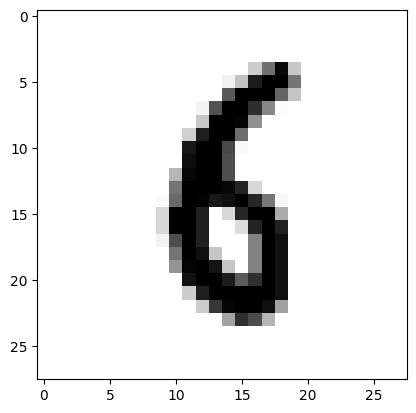

In [4]:
# Create an iterator for the training set
dataiter = iter(trainloader)
print("Type of dataiter:", type(dataiter))

# Get one batch of training data and labels
images, labels = next(dataiter)

# Display the first image from the batch
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.show()

In [5]:
print(images[0].shape) #para verificar as dimensões do tensor de cada imagem.
print(labels[0].shape) #para verificar a dimensão da label

torch.Size([1, 28, 28])
torch.Size([])


In [6]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 128)  # Input layer, 784 neurons connected to 128
        self.linear2 = nn.Linear(128, 64)  # Hidden layer 1, 128 neurons connected to 64
        self.linear3 = nn.Linear(64, 10)  # Hidden layer 2, 64 neurons connected to 10

    def forward(self, x):
        x = F.relu(self.linear1(x))  # Activation function from input layer to hidden layer 1
        x = F.relu(self.linear2(x))  # Activation function from hidden layer 1 to hidden layer 2
        x = self.linear3(x)  # Activation function from hidden layer 2 to output layer; in this case f(x) = x
        return F.log_softmax(x, dim=1)


In [7]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=.01, momentum=.5)  # Define the policy for weight and bias updates
    inicio = time()  # Timer to know how long the training took

    criterio = nn.NLLLoss()  # Defining the criterion to calculate the loss
    EPOCHS = 10  # Number of epochs the algorithm will run
    modelo.train()  # Activating the training mode of the model

    for epoch in range(EPOCHS):
        perda_acumulada = 0  # Initializing the accumulated loss for the current epoch

        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)  # Converting the images to vectors
            otimizador.zero_grad()  # Clearing the gradients because of the previous cycle

            output = modelo(images.to(device))  # Putting the data through the model
            perda_instantanea = criterio(output, labels.to(device))  # Calculating the instantaneous loss

            perda_instantanea.backward()  # Backpropagation based on the loss
            otimizador.step()  # Updating the weights and bias

            perda_acumulada += perda_instantanea.item()  # Updating the accumulated loss

        else:
            print("Epoch {} - Resulting Loss {}".format(epoch + 1, perda_acumulada / len(trainloader)))

    tempo_final = time()  # End time
    print('\nTraining time (in minutes)=', (tempo_final - inicio) / 60)
    
    return modelo

In [8]:
# def validacao(modelo, valloader, device):
#     conta_corretas, conta_todas = 0, 0
  
#     for images, labels in valloader:
#         for i in range(len(labels)):
#             img = images[i].view(1, 784)
            
#             # Turn off autograd to speed up validation. Dynamic computational graphs have a high processing cost.
#             with torch.no_grad():
#                 logps = modelo(img.to(device))  # Model output in log scale
                
#                 ps = torch.exp(logps)  # Convert to normal scale tensor
#                 probab = list(ps.cpu().numpy()[0])
#                 label_pred = probab.index(max(probab))  # Convert the tensor to a number, which the model predicted
#                 label_true = labels.numpy()[i]
                
#                 if label_true == label_pred:
#                     conta_corretas += 1
                  
#             conta_todas += 1
    
#     print('Total number of tested images=', conta_todas)
#     print('Total number of correctly classified images=', conta_corretas)
#     print('Model accuracy= {}%'.format(conta_corretas * 100 / conta_todas))


In [9]:
# from sklearn.metrics import confusion_matrix

# def validacao(modelo, valloader, device):
#     conta_corretas, conta_todas = 0, 0
#     y_true = []
#     y_pred = []
  
#     for images, labels in valloader:
#         for i in range(len(labels)):
#             img = images[i].view(1, 784)
            
#             # Turn off autograd to speed up validation. Dynamic computational graphs have a high processing cost.
#             with torch.no_grad():
#                 logps = modelo(img.to(device))  # Model output in log scale
                
#                 ps = torch.exp(logps)  # Convert to normal scale tensor
#                 probab = list(ps.cpu().numpy()[0])
#                 label_pred = probab.index(max(probab))  # Convert the tensor to a number, which the model predicted
#                 label_true = labels.numpy()[i]
                
#                 y_true.append(label_true)
#                 y_pred.append(label_pred)
                
#                 if label_true == label_pred:
#                     conta_corretas += 1
                  
#             conta_todas += 1
    
#     print('Total number of tested images=', conta_todas)
#     print('Total number of correctly classified images=', conta_corretas)
#     print('Model accuracy= {}%'.format(conta_corretas * 100 / conta_todas))
    
#     # Generate the confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     print('Confusion Matrix:')
#     print(cm)


In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
  
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [11]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    y_true = []
    y_pred = []
  
    for images, labels in valloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            
            with torch.no_grad():
                logps = modelo(img.to(device))
                
                ps = torch.exp(logps)
                probab = list(ps.cpu().numpy()[0])
                label_pred = probab.index(max(probab))
                label_true = labels.numpy()[i]
                
                y_true.append(label_true)
                y_pred.append(label_pred)
                
                if label_true == label_pred:
                    conta_corretas += 1
                  
            conta_todas += 1
    
    print('Total number of tested images=', conta_todas)
    print('Total number of correctly classified images=', conta_corretas)
    print('Model accuracy= {}%'.format(conta_corretas * 100 / conta_todas))
    
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:')
    print(cm)
    
    plot_confusion_matrix(cm, list(range(10)))

In [12]:
modelo = Modelo()  # Assuming 'modelo' is a class you've defined somewhere
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)
# Treinar o modelo
modelo_treinado = treino(modelo, trainloader, device)

Epoch 1 - Resulting Loss 1.2090748900702513
Epoch 2 - Resulting Loss 0.3832596557449176
Epoch 3 - Resulting Loss 0.30942173148872754
Epoch 4 - Resulting Loss 0.27101162349237307
Epoch 5 - Resulting Loss 0.24090812288161154
Epoch 6 - Resulting Loss 0.21671513672560644
Epoch 7 - Resulting Loss 0.19642167478831593
Epoch 8 - Resulting Loss 0.17894315175902742
Epoch 9 - Resulting Loss 0.1642630561503139
Epoch 10 - Resulting Loss 0.15089408150200906

Training time (in minutes)= 1.3003037095069885


Total number of tested images= 10000
Total number of correctly classified images= 9560
Model accuracy= 95.6%
Confusion Matrix:
[[ 965    0    1    2    0    3    6    1    1    1]
 [   0 1112    3    2    0    1    5    2   10    0]
 [  10    2  978   13    6    1    5    7    9    1]
 [   0    1    3  981    0    8    0    7    6    4]
 [   1    1    6    0  932    0   11    2    2   27]
 [   9    2    0   16    2  841    9    1    6    6]
 [   9    3    3    1    6    9  923    1    3    0]
 [   1   10   14   10    4    1    0  968    0   20]
 [   4    3    1   22    5    9   10    6  910    4]
 [   9    6    1   11   18    7    1    6    0  950]]


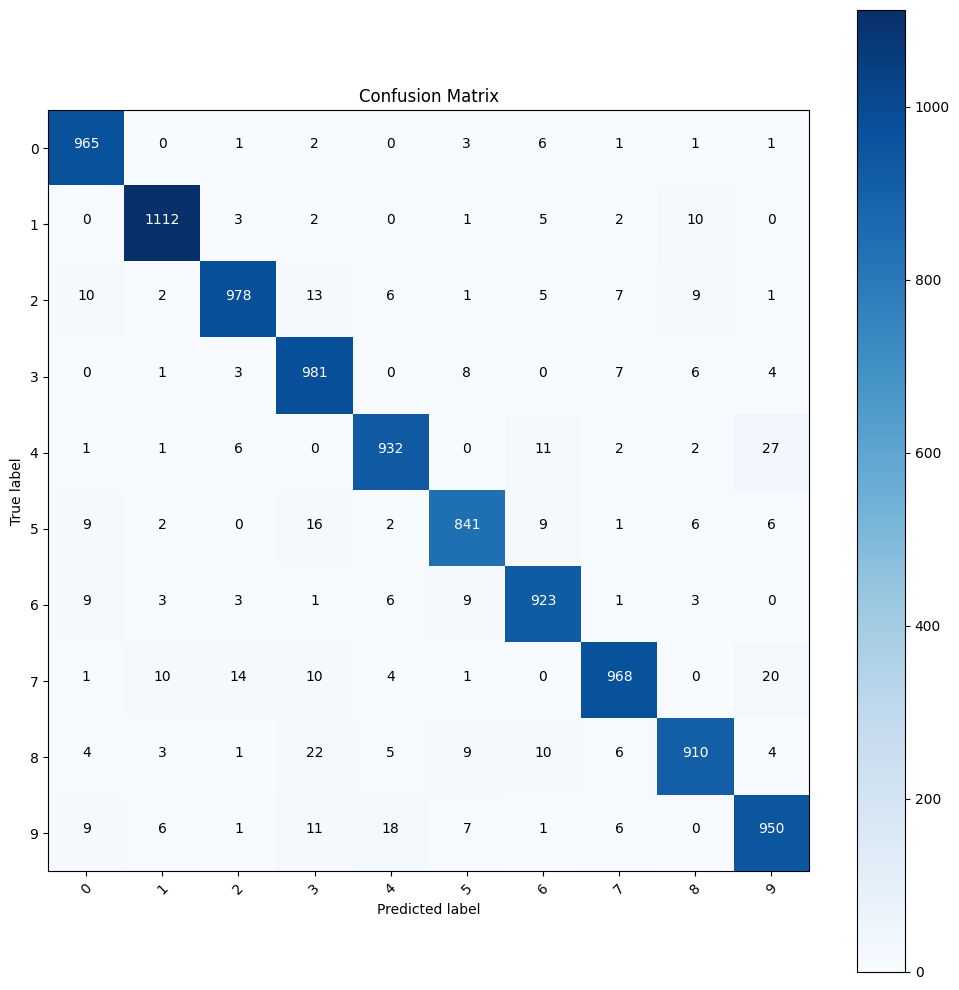

In [13]:
modelo_validado = validacao(modelo, valloader, device)